In [ ]:
import torch
from comfy.nodes import (
    CheckpointLoaderSimple,
    CLIPTextEncode,
    KSampler,
    VAEDecode,
    EmptyLatentImage,
)
from comfy.folder_paths import get_full_path, get_folder_paths

from PIL import Image
import numpy as np


def save_image(image: torch.Tensor, filename: str):
    """
    Save a single image to a file.

    Args:
    image (torch.Tensor): A tensor representing the image, expected to be in the format [H, W, C] with values in range [0, 1].
    filename (str): output filename
    """
    # Prepare the image for saving
    i = 255.0 * image.cpu().numpy()
    img = Image.fromarray(np.clip(i, 0, 255).astype(np.uint8))

    img.save(filename, compress_level=4)



prompt = "A beautiful landscape with mountains and a lake"
negative_prompt = "ugly, blurry, low quality"
steps = 20
cfg = 7.0
seed = 42
width = 512
height = 512


model_type EPS


Using pytorch attention in VAE
Using pytorch attention in VAE
clip missing: ['clip_l.logit_scale', 'clip_l.transformer.text_projection.weight']
Requested to load SD1ClipModel
Loading 1 new model
Requested to load BaseModel
Loading 1 new model
100%|██████████| 20/20 [00:01<00:00, 15.13it/s]
Requested to load AutoencoderKL
Loading 1 new model


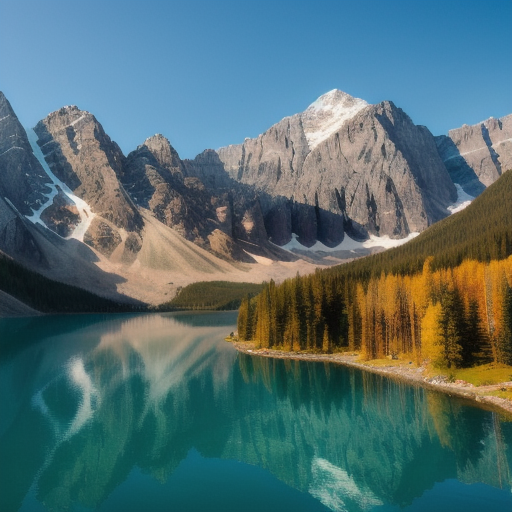

In [4]:
with torch.inference_mode():
    # Step 1: Load the model checkpoint
    checkpoint_loader = CheckpointLoaderSimple()
    model, clip, vae, _ = checkpoint_loader.load_checkpoint(  # type: ignore
        "Realistic_Vision_V5.safetensors"
    )
    # Step 2: Encode the prompt
    clip_text_encode = CLIPTextEncode()
    positive_conditioning = clip_text_encode.encode(clip, prompt)[0]
    negative_conditioning = clip_text_encode.encode(clip, negative_prompt)[0]

    # Step 3: Create an empty latent image
    empty_latent = EmptyLatentImage()
    latent = empty_latent.generate(width, height, 1)[0]

    # Step 4: Run the sampler
    k_sampler = KSampler()
    sampled_latent = k_sampler.sample(
        model,
        seed,
        steps,
        cfg,
        "euler_ancestral",  # Sampler name
        "exponential",  # Scheduler
        positive_conditioning,
        negative_conditioning,
        latent,
    )[0]

    # Step 5: Decode the latent image
    vae_decode = VAEDecode()
    decoded_image = vae_decode.decode(vae, sampled_latent)[0]
Image.fromarray(np.clip(decoded_image.squeeze(0).cpu().numpy() * 255, 0, 255).astype(np.uint8))

model_type EPS


Using pytorch attention in VAE
Using pytorch attention in VAE
clip missing: ['clip_l.logit_scale', 'clip_l.transformer.text_projection.weight']
Requested to load SD1ClipModel
Loading 1 new model
Requested to load BaseModel
Loading 1 new model
100%|██████████| 10/10 [00:06<00:00,  1.66it/s]
Requested to load AutoencoderKL
Loading 1 new model


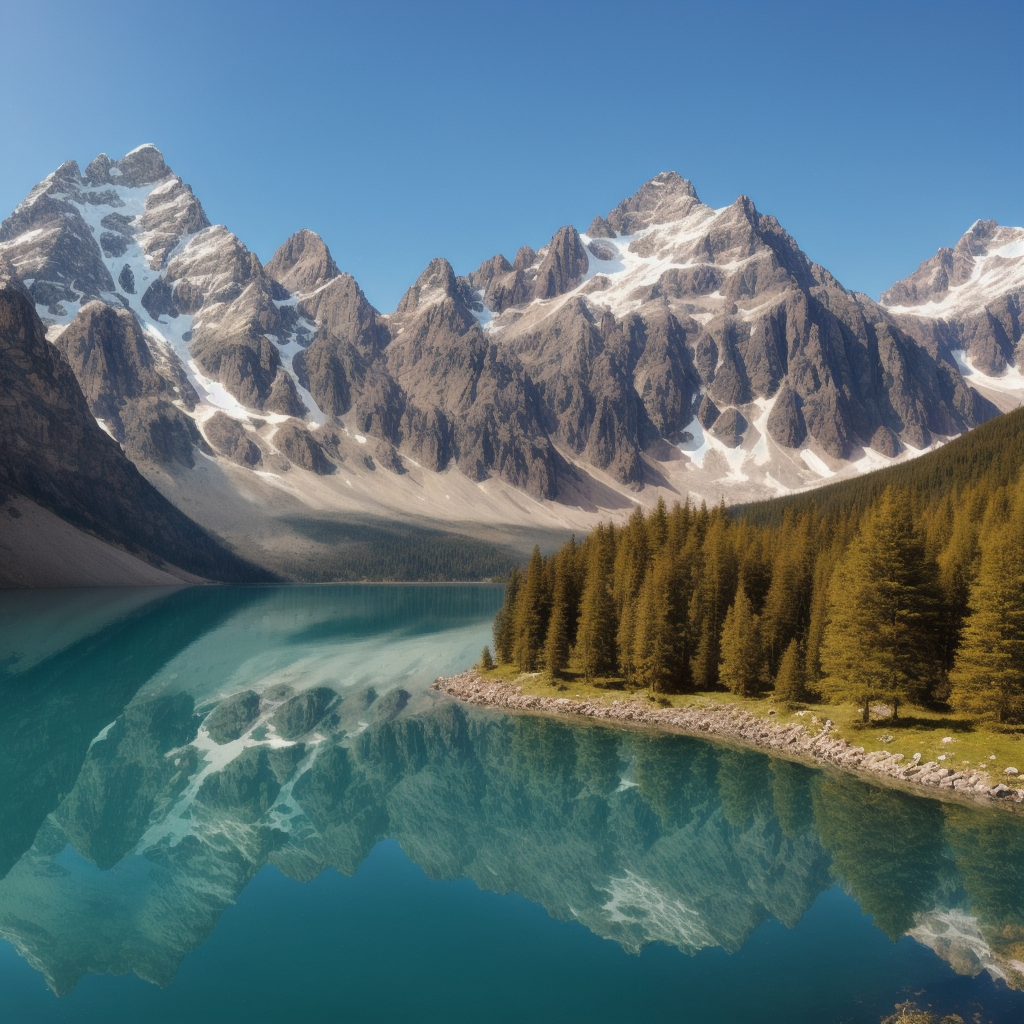

In [15]:
from typing import Optional
import torch
from pydantic import Field
from comfy.nodes import LatentUpscale
from nodetool.metadata.types import CheckpointFile, ImageRef
from nodetool.workflows.base_node import BaseNode
from nodetool.workflows.processing_context import ProcessingContext
import numpy as np
import PIL.Image

with torch.inference_mode():
    # Step 1: Load the model checkpoint
    checkpoint_loader = CheckpointLoaderSimple()
    model, clip, vae, _ = checkpoint_loader.load_checkpoint(  # type: ignore
        "Realistic_Vision_V5.safetensors"
    )
    
    clip_text_encode = CLIPTextEncode()
    positive_conditioning = clip_text_encode.encode(
        clip, prompt
    )[0]
    negative_conditioning = clip_text_encode.encode(
        clip, negative_prompt
    )[0]

    empty_latent = EmptyLatentImage()
    latent = empty_latent.generate(width, height, 1)[0]

    k_sampler = KSampler()
    
    # Step 4: Run the sampler
    k_sampler = KSampler()
    sampled_latent = k_sampler.sample(
        model,
        seed,
        steps,
        cfg,
        "euler_ancestral",  # Sampler name
        "normal",  # Scheduler
        positive_conditioning,
        negative_conditioning,
        latent,
    )[0]
    
    hires_latent = LatentUpscale().upscale(
        samples=sampled_latent,
        upscale_method="nearest-exact",
        width=1024,
        height=1024,
        crop=True
    )[0]

    hires_steps = 10
    hires_denoise = 0.5

    # Second pass
    sampled_latent_2 = k_sampler.sample(
        model=model,
        seed=seed,
        steps=hires_steps,
        cfg=cfg,
        sampler_name="dpmpp_sde",
        scheduler="normal",
        positive=positive_conditioning,
        negative=negative_conditioning,
        latent_image=hires_latent,
        denoise=hires_denoise
    )[0]

    vae_decode = VAEDecode()
    decoded_image = vae_decode.decode(vae, sampled_latent_2)[0]

PIL.Image.fromarray(
    np.clip(decoded_image.squeeze(0).cpu().numpy() * 255, 0, 255).astype(
        np.uint8
    )
)